# Capítulo 5 – Detección de Anomalías con Análisis de Componentes Principales (PCA)

El **Análisis de Componentes Principales (PCA)** es un método estadístico ampliamente utilizado para la reducción de dimensionalidad.  
Su propósito es transformar un conjunto de variables posiblemente correlacionadas en un nuevo conjunto de variables ortogonales denominadas *componentes principales*, que capturan la mayor parte de la varianza de los datos originales.

En el contexto de la detección de anomalías, el fundamento es que los datos normales pueden representarse adecuadamente en un subespacio de baja dimensión, mientras que las observaciones anómalas tienden a presentar **errores de reconstrucción elevados** o a situarse en regiones de baja varianza explicada.

## ¿Por qué PCA?

Las razones principales para emplear PCA en la detección de anomalías son:

- Permite **extraer la estructura subyacente** de los datos, reduciendo ruido y redundancia.
- Identifica observaciones que **no se ajustan bien** al subespacio de máxima varianza.
- Es un modelo **interpretativo**, ya que muestra qué variables contribuyen a cada componente principal.
- Es aplicable tanto a **datos tabulares** como a **series temporales multivariantes**, una vez que se preprocesan en forma de ventanas.

## Intuición

El PCA busca un subespacio de menor dimensión que explique la mayor parte de la variabilidad de los datos.  
La idea central puede expresarse así:

> “Si un punto no puede reconstruirse bien a partir de los componentes principales, probablemente sea una anomalía.”

En la práctica, los datos normales se alinean con las direcciones de mayor varianza, mientras que las anomalías quedan fuera de ese subespacio y presentan un **error de reconstrucción más alto**.

## Fundamento Teórico

Sea $X \in \mathbb{R}^{n \times d}$ un conjunto de $n$ observaciones y $d$ variables:

1. Se centra la matriz restando la media.
2. Se calcula la matriz de covarianza:  
   $$
   \Sigma = \frac{1}{n} X^T X
   $$
3. Se obtienen los vectores propios (componentes) y valores propios (varianza explicada).
4. Se proyectan los datos en los $k$ primeros componentes:  
   $$
   Z = X W_k
   $$
   donde $W_k$ contiene los $k$ vectores propios principales.
5. Se reconstruyen los datos:  
   $$
   \hat{X} = Z W_k^T
   $$

El **error de reconstrucción** para cada observación $x_i$ se define como:
$$
e_i = \lVert x_i - \hat{x}_i \rVert^2
$$

## Interpretación del Score

- **Error bajo** → El punto se ajusta al subespacio → normalidad.  
- **Error alto** → El punto queda fuera del subespacio → posible anomalía.  

Un umbral común se establece como:
$$
\tau = \mu_e + 3\sigma_e
$$
donde $\mu_e$ y $\sigma_e$ corresponden a la media y desviación estándar de los errores de reconstrucción en los datos de entrenamiento.

## Parámetros Clave

- **n_components**: número de componentes principales a retener.  
  - Demasiados → el error disminuye, pero se pierde capacidad de discriminación.  
  - Muy pocos → se omite información relevante.  
- **Threshold**: umbral para clasificar anomalías. Puede fijarse estadísticamente o mediante percentiles.

## Ventajas

- Método **simple, rápido y bien establecido**.
- Fácil de interpretar desde el punto de vista estadístico.
- Útil como **baseline** frente a modelos más avanzados.
- Detecta anomalías en combinaciones de variables, no solo en valores individuales.

## Limitaciones

- Es un método **lineal**: no captura dependencias no lineales.
- Sensible a la **escala de los datos**, por lo que requiere normalización.
- No detecta anomalías que ocurren dentro del mismo subespacio de mayor varianza.

### Ejemplo conceptual

Consideremos un sistema con dos variables: **RPM** y **temperatura del refrigerante**.

- En condiciones normales, los puntos se alinean en una dirección oblicua (a mayor RPM, mayor temperatura).  
- El PCA proyecta los datos en esa dirección principal.  
- Un punto con **temperatura muy baja para RPM altas** generará un error de reconstrucción elevado y se identificará como anomalía.


## Implementación de un modelo para detección de anomalías en series temporales

Para la implementación del modelo de este capítulo y los posteriores, se define primero una **interfaz base** de la que heredarán los distintos detectores de anomalías.  

El motivo de este enfoque es que, cuando llegue el momento de realizar validaciones o ejecutar flujos completos de experimentos, podamos **automatizar el procedimiento** y evitar código duplicado.  

Esta interfaz base contendrá los métodos esenciales que todo modelo de detección de anomalías debe implementar. A continuación se muestra su definición.


In [1]:
from abc import ABC, abstractmethod

class BaseAnomalyDetector(ABC):
    @abstractmethod
    def fit(self, X):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def anomaly_score(self, X):
        pass

    def preprocess(self, X, retrain=False):
        return X


Para decidir los métodos que contiene la clase base nos apoyamos en una definición **universal de modelo**, en la que se consideran los siguientes elementos:

- **fit**: ajustar el modelo a los datos de entrenamiento.  
- **predict**: realizar la predicción, es decir, decidir si una observación es normal o anómala.  
- **anomaly_score**: obtener un valor continuo que cuantifique el grado de anomalía de cada instante de tiempo.  
- **preprocess**: transformar los datos antes del entrenamiento o la predicción, en caso de que el modelo lo requiera (normalización, escalado, etc.).  


## Implementación de un detector con PCA

Para implementar un modelo de detección de anomalías en series temporales con **PCA**, utilizaremos la implementación de PCA disponible en `scikit-learn`.  

El enfoque consiste en aprovechar la capacidad del PCA para **reducir la dimensionalidad** de los datos, proyectándolos en un subespacio de menor dimensión y posteriormente **reconstruirlos**.  

La diferencia entre la señal original y su reconstrucción nos proporciona el **error de reconstrucción**, que sirve como valor continuo para evaluar el grado de anomalía de cada observación.


### Clase PCAAnomalyDetector

A continuación se define la clase `PCAAnomalyDetector`, que hereda de la interfaz base `BaseAnomalyDetector`.  
Iremos implementando sus métodos paso a paso, comenzando por el constructor y los atributos principales.


In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class PCAAnomalyDetector(BaseAnomalyDetector):
    def __init__(self, n_components=None, threshold=None):
        """
        n_components: número de componentes principales a retener.
                      Si None, se usa el criterio de máxima varianza explicada.
        threshold: percentil (ej. 0.95 => 95% de los errores por debajo).
        """
        self.n_components = n_components
        self.threshold = threshold
        self.pca = None
        self.scaler = None
        self._threshold_value = None


#### Método `preprocess`

En este caso, la idea es permitir un escalado de variables mediante `StandardScaler` (aunque se puede extender).  
Si no se define ningún `scaler`, se devuelven los datos tal cual.


In [3]:
    def preprocess(self, X, retrain=True):
        X = np.asarray(X, dtype=np.float32)
        if self.scaler:
            if retrain:
                return self.scaler.fit_transform(X)
            else:
                return self.scaler.transform(X)
        return X


#### Método `fit`

El método `fit` ajusta el modelo PCA a los datos de entrenamiento.  
Posteriormente, se calcula el **error de reconstrucción** para cada observación y se determina un umbral basado en el percentil definido (`threshold`).  
Si no se especifica, se usa por defecto un percentil alto (≈ 0.997), equivalente a tres desviaciones estándar.


In [4]:
    def fit(self, X):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)

        errors = self._reconstruction_error(X)
        q = self.threshold if self.threshold is not None else 0.997
        self._threshold_value = np.quantile(errors, q)

#### Métodos `predict` y `anomaly_score`

- `predict`: clasifica cada observación como **normal (0)** o **anómala (1)**, comparando su error de reconstrucción con el umbral.  
- `anomaly_score`: devuelve directamente el valor continuo del error de reconstrucción, útil para métricas como ROC AUC o curvas de precisión-recall.


In [5]:
    def predict(self, X):
        errors = self._reconstruction_error(X)
        return np.where(errors > self._threshold_value, 1, 0)

    def anomaly_score(self, X):
        return self._reconstruction_error(X)

#### Método privado `_reconstruction_error`

Esta función auxiliar calcula el error cuadrático medio entre la muestra original y su reconstrucción a partir de los componentes principales.  
Es la base para obtener tanto las etiquetas como los scores de anomalía.


In [6]:
    def _reconstruction_error(self, X_proc):
        X_projected = self.pca.inverse_transform(self.pca.transform(X_proc))
        errors = np.mean((X_proc - X_projected) ** 2, axis=1)
        return np.asarray(errors)

Como se puede apreciar, la implementación de este modelo es relativamente simple.  
El PCA se fundamenta en **principios estadísticos básicos** y se apoya en un concepto intuitivo.  

Esto lo convierte en un modelo ideal como **baseline** en tareas de detección de anomalías.

## Validación de un modelo de series temporales

Una vez que tenemos un modelo implementado, necesitamos **probar su funcionamiento**.  
Para ello, definimos un flujo de actuación general que seguirá cualquier experimento:

1. Obtener los datos.  
2. Preprocesarlos si es necesario.  
3. Entrenar el modelo.  
4. Obtener predicciones y scores de anomalía.  
5. Evaluar resultados con métricas y gráficos.  

Este proceso se automatiza mediante un **pipeline de validación**, que permite aplicar siempre la misma lógica a distintos modelos y datasets.

### Pipeline de Validación

La validación de un modelo en series temporales requiere un proceso sistemático que incluya:

1. **División temporal de los datos**: mediante *time series cross-validation* (ventana expansiva) o *walkforward*.  
2. **Preprocesamiento opcional**: como la limpieza de valores extremos mediante filtro de Hampel.  
3. **Entrenamiento y predicción** en cada split.  
4. **Evaluación de métricas** sobre los bloques de validación.  

Para estandarizar este flujo, se implementa la clase `ValidationPipeline`, que ya se encuentra en el módulo `modelos/ValidationPipeline.py`.  


In [7]:
from modelos.ValidationPipeline import ValidationPipeline

La clase `ValidationPipeline` es agnóstica al modelo: cualquier detector que herede de 
`BaseAnomalyDetector` puede utilizarse en este pipeline, ya que se espera que implemente 
los métodos `fit`, `predict` y `anomaly_score`.  

En la práctica, esto significa que podemos validar un modelo PCA, Isolation Forest u otro 
algoritmo siguiendo siempre la misma estructura de flujo.

### Función `run_experiment`

Una vez que tenemos definido el `ValidationPipeline`, es útil disponer de una función de más alto nivel que nos permita **ejecutar experimentos completos de validación** con un modelo.  

La función `run_experiment` se encuentra implementada en el proyecto (archivo `runner.py`) y se encarga de:

1. **Grid search**: probar todas las combinaciones de hiperparámetros definidas en `param_grid`.  
2. **Validación cruzada temporal**: aplicar el `ValidationPipeline` para cada configuración y calcular métricas.  
3. **Selección de top-k**: ordenar las configuraciones según una métrica objetivo (ej. NAB, F1, ROC AUC).  
4. **Evaluación en test**: reentrenar con la mejor configuración y evaluar en el conjunto de test.  
5. **Visualización**: generar gráficos que permiten entender mejor el rendimiento del modelo.  


In [8]:
from runner import run_experiment

#### Feedback de la validación

Al ejecutar un experimento con `run_experiment` obtenemos dos tipos de feedback:

1. **Tablas de resultados**
   - Métricas en validación para todas las configuraciones del grid search.  
   - Tabla con las `top-k` mejores configuraciones.  
   - Métricas finales en el conjunto de test.  

2. **Gráficas de apoyo**
   - **Curva PR (Precision-Recall)**: útil en problemas desbalanceados como la detección de anomalías.  
   - **Curva ROC**: muestra la relación entre tasa de verdaderos positivos y tasa de falsos positivos.  
   - **Matriz de confusión**: resume aciertos y errores de clasificación.  
   - **Histograma de scores**: distribución de los valores de anomalía, con umbral marcado si aplica.  
   - **Cobertura temporal**: gráfico que compara anomalías reales y predichas en la línea temporal.  
   - **Cobertura por evento**: barras que muestran cuántos eventos anómalos fueron correctamente detectados.  

Este feedback permite no solo cuantificar el rendimiento con métricas, sino también **visualizar cómo responde el modelo frente a anomalías reales**.

## Experimento con PCA en señales sintéticas

Antes de aplicar el modelo PCA a un dataset real, realizamos un primer experimento sobre datos **sintéticos**.  
Para ello, contamos con la función `generate_synthetic_timeseries` implementada en `utils.py`, que permite generar señales multivariantes con anomalías inyectadas de diferentes tipos (picos, drift, tramos planos, ruido).  

El flujo del experimento será:

1. Generar los datos sintéticos y preparar los conjuntos de train/val/test.  
2. Definir las métricas de evaluación.  
3. Configurar el grid de hiperparámetros de PCA.  
4. Ejecutar el experimento con `run_experiment`.  


In [9]:
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.PCAAnomalyDetector import PCAAnomalyDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

### 1. Generación de datos sintéticos

Se crean tres señales (`f1`, `f2`, `f3`) con diferente dinámica (sinusoidal, cuadrada y random walk), a las que se añaden anomalías inyectadas de forma aleatoria.  

Posteriormente, se dividen los datos en **train, validation y test**, y se concatenan train+val para la fase de validación cruzada.


In [10]:
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.01, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

#### Visualización de las señales sintéticas

Antes de entrenar el modelo, es útil observar las señales generadas y las anomalías inyectadas.  

En el siguiente gráfico se muestran las tres señales (`f1`, `f2`, `f3`) junto con:

- Los instantes de anomalías reales (en rojo).  
- La división de los datos en *train* (verde), *validation* (naranja) y *test* (morado).  

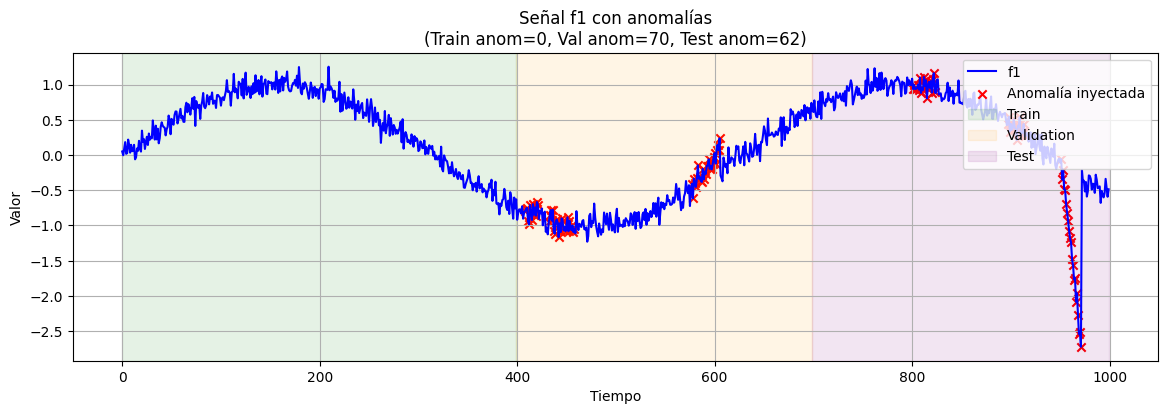

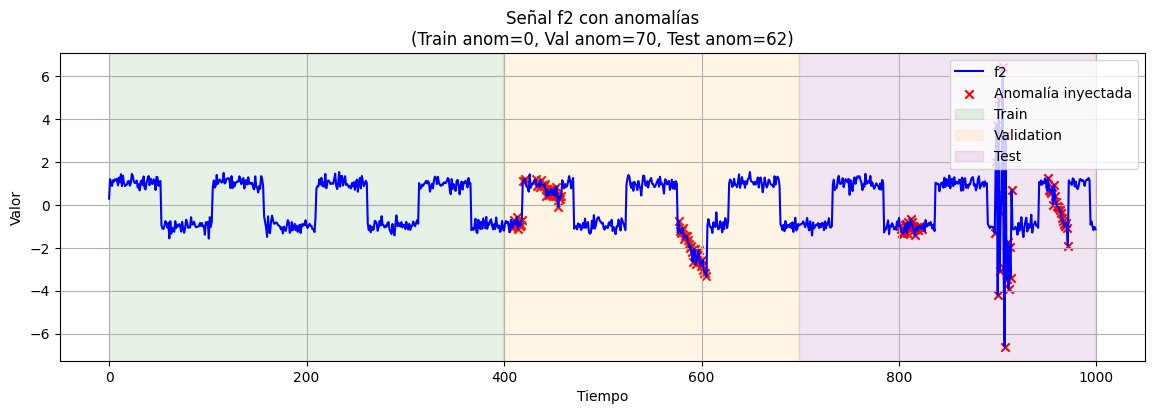

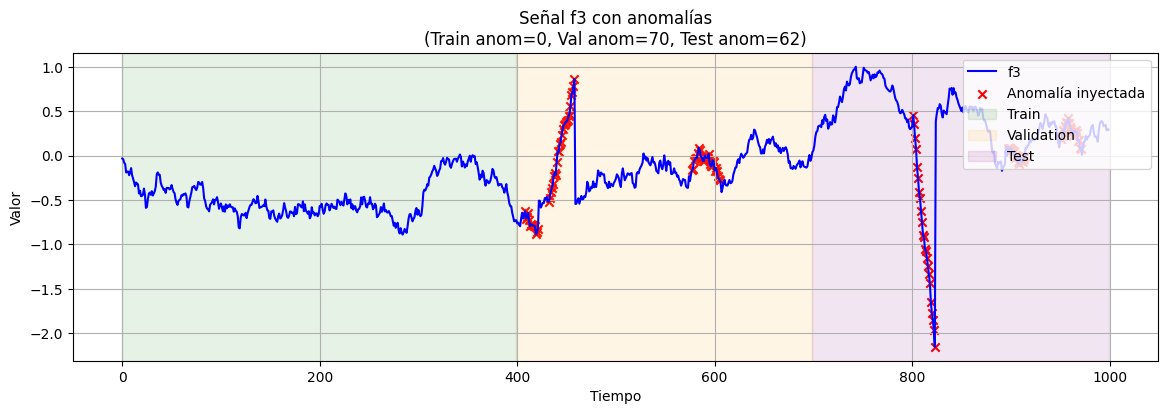

In [11]:
import matplotlib.pyplot as plt

# Concatenamos todos los splits para visualizar la serie completa
full_df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Límites de los splits
train_end = df_train["timestamp"].max()
val_end = df_val["timestamp"].max()

for col in ["f1", "f2", "f3"]:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(full_df["timestamp"], full_df[col], label=f"{col}", color="blue")

    # Anomalías
    anomaly_idx = full_df[full_df["anomaly"] == 1].index
    ax.scatter(
        full_df.loc[anomaly_idx, "timestamp"],
        full_df.loc[anomaly_idx, col],
        color="red", marker="x", label="Anomalía inyectada"
    )

    # Fondos para train / val / test
    ax.axvspan(full_df["timestamp"].min(), train_end, alpha=0.1, color="green", label="Train")
    ax.axvspan(train_end, val_end, alpha=0.1, color="orange", label="Validation")
    ax.axvspan(val_end, full_df["timestamp"].max(), alpha=0.1, color="purple", label="Test")

    ax.set_title(
        f"Señal {col} con anomalías\n"
        f"(Train anom={df_train['anomaly'].sum()}, "
        f"Val anom={df_val['anomaly'].sum()}, "
        f"Test anom={df_test['anomaly'].sum()})"
    )
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Valor")
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()


### 2. Definición de métricas

Se emplean varias métricas para evaluar el rendimiento del modelo:

- **Precisión, Recall, F1**: métricas clásicas de clasificación.  
- **ROC AUC**: mide la capacidad de discriminación del score continuo.  
- **NAB**: métrica específica para detección temprana de anomalías.  
- **Window coverage**: mide la proporción de ventanas anómalas correctamente cubiertas.  

In [12]:
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

### 3. Definición del grid de hiperparámetros

En PCA, los principales hiperparámetros son:

- **n_components**: número de componentes principales a retener.  
- **threshold**: percentil usado como umbral para decidir qué puntos son anómalos.  

Probamos distintas configuraciones de ambos parámetros.

In [13]:
param_grid_pca = {
    "n_components": [1, 2, 3],
    "threshold": [0.90, 0.95, 0.99, 0.997]
}

### 4. Ejecución del experimento

Con `run_experiment` se ejecuta el pipeline de validación:

- Se realiza un grid search con validación cruzada temporal (tscv).  
- Se seleccionan las **5 mejores configuraciones** según la métrica NAB.  
- Se reentrena con train+val y se evalúa en test.  
- Se generan tablas de resultados y gráficas de rendimiento.  


Evaluación en test: 100%|██████████| 5/5 [00:00<00:00, 236.48it/s]

Top 5 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_cov,n_components,threshold
8,0.216,0.094,0.130,0.641,0.896,0.094,3,0.900
9,0.178,0.072,0.101,0.641,0.884,0.072,3,0.950
10,0.150,0.018,0.032,0.641,0.862,0.018,3,0.990
7,0.150,0.075,0.094,0.836,0.832,0.075,2,0.997
11,0.100,0.013,0.022,0.641,0.827,0.013,3,0.997


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_cov,n_components,threshold
0,0.654,0.274,0.386,0.585,0.852,0.284,3.0,0.900
1,0.684,0.210,0.321,0.585,0.864,0.213,3.0,0.950
2,0.714,0.081,0.145,0.585,0.877,0.082,3.0,0.990
3,0.053,0.129,0.075,0.190,-1.000,0.116,2.0,0.997
4,0.750,0.048,0.091,0.585,0.895,0.053,3.0,0.997


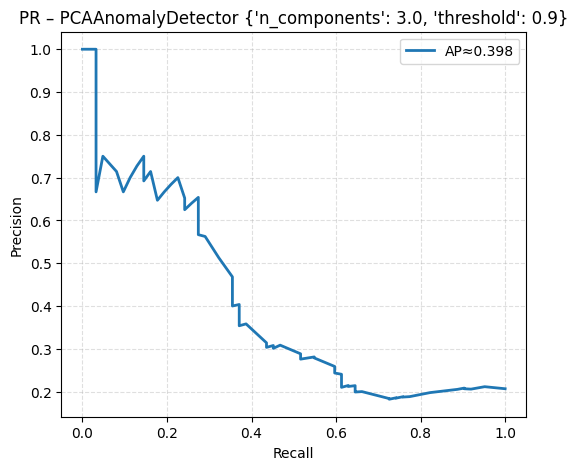

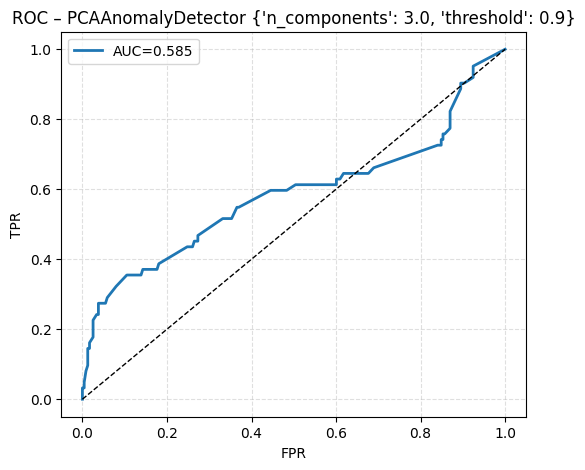

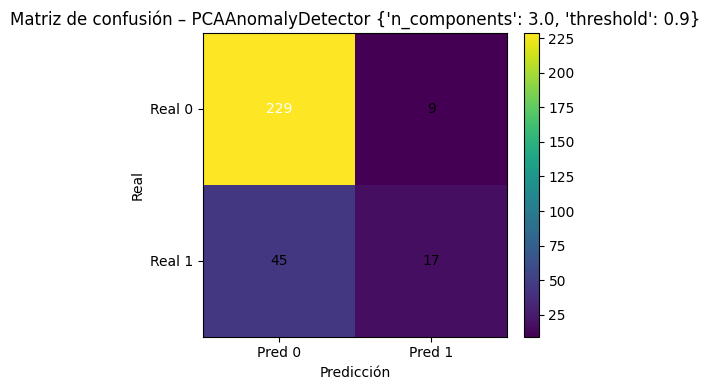

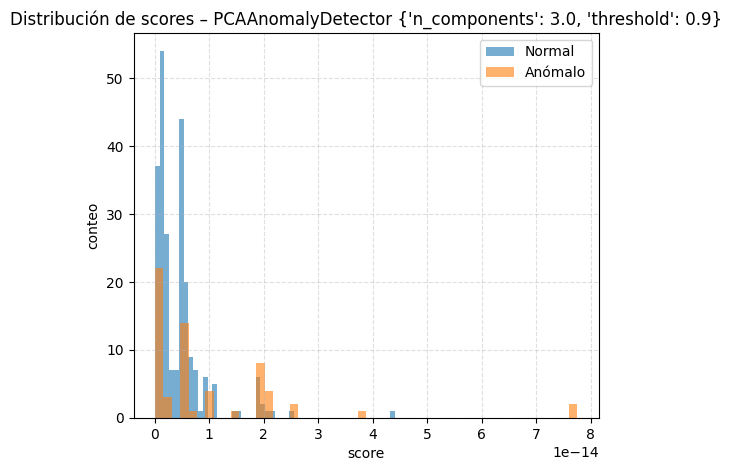

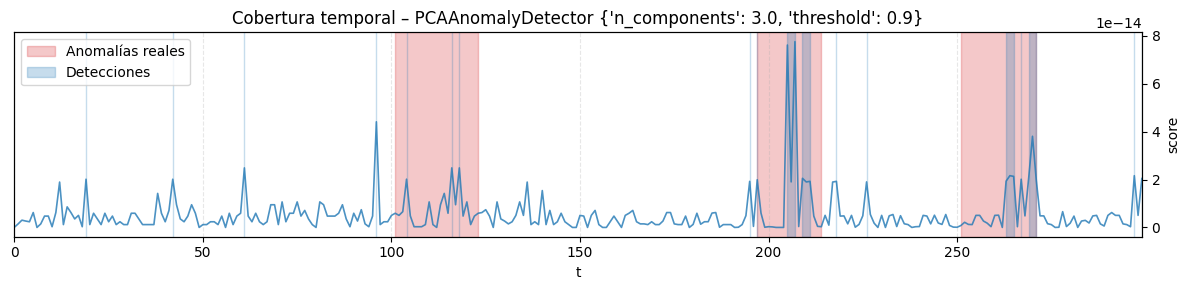

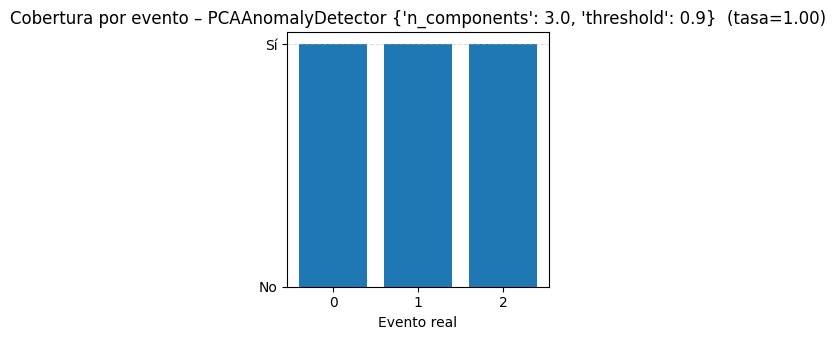

In [14]:
df_results, top5, df_final = run_experiment(
    model_class=PCAAnomalyDetector,
    param_grid=param_grid_pca,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 20},
    mode="tscv",
    sort_metric="nab",
    top_k=5,
    plot_mode="best"
)

## Experimentos globales con PCA en datasets reales

Después de validar el PCA sobre señales sintéticas, aplicamos el mismo flujo de validación sobre varios datasets reales del proyecto.  

La función `run_dataset_experiment` permite automatizar este proceso para cada dataset:  
- Carga los datos (train, val, test).  
- Ajusta el tamaño relativo de las ventanas para validación cruzada temporal.  
- Ejecuta el grid search sobre hiperparámetros del modelo.  
- Evalúa los resultados en test y genera feedback en forma de métricas y gráficas.  

Al final, obtendremos un **resumen comparativo** de los mejores resultados de PCA en todos los datasets.

In [15]:
import os
import pandas as pd
from modelos.PCAAnomalyDetector import PCAAnomalyDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_dataset_experiment

# 1. Configuración global
datasets = ["BATADAL", "SKAB", "WADI", "EbayRanSynCoders", "SMAP", "MSL"]

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

param_grid_pca = {
    "n_components": [1, 2, 3],
    "threshold": [0.90, 0.95, 0.99, 0.997]
}


### 2. Ejecución de experimentos

Se lanza un experimento de validación para cada dataset de la lista.  

Al final se guarda un resumen con los mejores resultados por dataset en términos de NAB, junto con otras métricas relevantes como F1, precisión y recall.


In [16]:

# 2. Lanzar experimentos
results_all = {}
summary_rows = []

for ds in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=ds,
        model_class=PCAAnomalyDetector,
        param_grid=param_grid_pca,
        metrics=metrics,
        params_cv={"num_windows": 10},
        mode="tscv",
        sort_metric="nab",
        top_k=5,
        plot_mode="best"  # cambiar a "none" si quieres correr en batch sin plots
    )
    
    results_all[ds] = {
        "grid": df_results,
        "topk": topk,
        "final": df_final
    }
    
    # resumen rápido para comparar datasets
    best_row = df_final.iloc[df_final["nab"].idxmax()]
    summary_rows.append({
        "dataset": ds,
        "best_nab": best_row["nab"],
        "best_f1": best_row["f1"],
        "best_prec": best_row["precision"],
        "best_recall": best_row["recall"]
    })

summary_df = pd.DataFrame(summary_rows)
print("\n=== Resumen de mejores resultados por dataset (PCA) ===")
print(summary_df)


🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde D:\TFG\TFG\Avance\MDF-ANOMALY-DETECTION\modelos\data\BATADAL\data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas


Grid search:  42%|████▏     | 5/12 [33:39<47:07, 403.95s/config]  


KeyboardInterrupt: 

## Conclusión del capítulo

En este capítulo se ha mostrado el uso de **PCA como modelo base** para la detección de anomalías en series temporales.  
Se ha explicado su fundamento teórico, su implementación como detector, y se ha visto cómo validar su rendimiento tanto sobre señales sintéticas como sobre datasets reales.  

Este análisis constituye un **punto de partida** para la comparación con métodos más avanzados que se estudiarán en los siguientes capítulos.


---

## Referencias

- Jolliffe, Ian T., and Jorge Cadima.  
**"Principal component analysis: a review and recent developments."** *Philosophical Transactions of the Royal Society A* 374.2065 (2016): 20150202.

- Shyu, Mei-Ling, et al.  
**"A novel anomaly detection scheme based on principal component classifier."** *Proceedings of the IEEE Foundations and New Directions of Data Mining Workshop*. 20